C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 30, 1])) that is different to the input size (torch.Size([30, 30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.17836274206638336
Epoch 10, Loss: 0.09660658240318298
Epoch 20, Loss: 0.09629049152135849
Epoch 30, Loss: 0.09704950451850891
Epoch 40, Loss: 0.09716176241636276
Epoch 50, Loss: 0.09674187749624252
Epoch 60, Loss: 0.09697084128856659
Epoch 70, Loss: 0.09627552330493927
Epoch 80, Loss: 0.09650609642267227
Epoch 90, Loss: 0.09696351736783981
Epoch 100, Loss: 0.09607364237308502
Epoch 110, Loss: 0.09576661139726639
Epoch 120, Loss: 0.09518647193908691
Epoch 130, Loss: 0.06278879940509796
Epoch 140, Loss: 0.0385969914495945
Epoch 150, Loss: 0.025602029636502266
Epoch 160, Loss: 0.024773012846708298
Epoch 170, Loss: 0.029292935505509377
Epoch 180, Loss: 0.019932683557271957
Epoch 190, Loss: 0.029209285974502563
Epoch 200, Loss: 0.024923432618379593
Epoch 210, Loss: 0.031140999868512154
Epoch 220, Loss: 0.02508542127907276
Epoch 230, Loss: 0.02815759740769863
Epoch 240, Loss: 0.019077608361840248
Epoch 250, Loss: 0.022372815757989883
Epoch 260, Loss: 0.024425379931926727
Epo

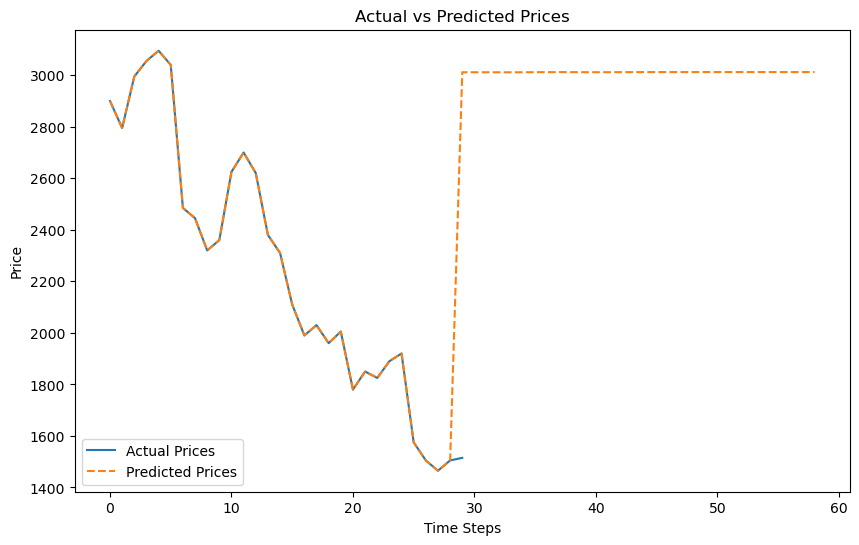

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

# 데이터 로딩 함수
def get_bitcoin_data_60_days():
    url = "https://api.upbit.com/v1/candles/days"
    querystring = {"market":"KRW-ARB","count":"60"}
    response = requests.get(url, params=querystring)
    data = response.json()
    df = pd.DataFrame(data)[['candle_date_time_kst', 'trade_price']]
    df.columns = ['DateTime', 'Close']
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    return df

# 데이터 전처리
df = get_bitcoin_data_60_days()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df['Close'].values.reshape(-1,1))

class StockDataset(Dataset):
    def __init__(self, data, input_window, output_window, stride):
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride
        self.data = data

        self.X = []
        self.y = []
        start = 0
        while start + input_window + output_window <= len(data):
            self.X.append(data[start:start+input_window])
            self.y.append(data[start+input_window:start+input_window+output_window])
            start += stride

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.y[idx]).float()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_window, output_window, feature_size, num_layers, num_heads):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()
        self.input_window = input_window
        self.output_window = output_window
        self.feature_size = feature_size

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = x * math.sqrt(self.feature_size)
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x)
        output = self.decoder(output)
        return output

# 데이터셋 및 데이터 로더 준비
input_window = 30
output_window = 1
stride = 1
dataset = StockDataset(df_scaled, input_window, output_window, stride)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_window, output_window, feature_size=16, num_layers=4, num_heads=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# 학습 루프
model.train()
epochs = 1000
for epoch in range(epochs):
    total_loss = 0
    for x, y in loader:
        x = x.transpose(0, 1).to(device)
        y = y.transpose(0, 1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(loader)}')

# 최근 데이터를 사용하여 예측
recent_data = df_scaled[-input_window:].reshape(1, input_window, -1)
recent_data_tensor = torch.from_numpy(recent_data).float()

# 예측 실행
model.eval()
with torch.no_grad():
    predicted_normalized = model(recent_data_tensor.to(device))
    predicted = scaler.inverse_transform(predicted_normalized.cpu().numpy().reshape(-1, 1))

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
actual_prices = scaler.inverse_transform(df_scaled[-input_window:].reshape(-1, 1))
predicted_prices = np.concatenate((actual_prices[:-output_window], predicted), axis=0)
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()
